In [35]:
import random
from collections import defaultdict
from itertools import product
import copy
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Map from Dice Roll To Probability of it Happening over Two Dice
dice_probs = {}
for d1 in range(1, 7):
    for d2 in range(1, 7):
        total = d1 + d2
        if total not in dice_probs:
            dice_probs[total] = 0
        dice_probs[total] += 1.0/36.0

# Map From Dice Roll To Possible Tiles to Flip Down
tile_lookup = defaultdict(list)
tiles = tuple([True for x in range(1, 10)])
tile_values = list(range(1,10))
for l in product([0,1], repeat=9):
    total = 0
    for i, elem in enumerate(l):
        total += l[i] * tile_values[i]
    if 2 <= total <= 12:
        tile_lookup[total].append(l)

In [6]:
def valid_move(move, tiles):
    """
    :param move: list of int, tiles to attempt to flip down
    :param tiles: list of int, tiles currently on the board
    :return: Bool is the move valid for tiles on the board
    """
    for i in range(len(move)):
        if move[i] == 1 and tiles[i] != 1:
            return False
    return True

def flip_tiles(move, tiles):
    """
    :param move: list of int, tiles to attempt to flip down
    :param tiles: list of int, tiles currently on the board
    :return: list of int, the new board
    """
    retval = []
    for i in range(len(move)):
        if move[i] == 1:
            retval.append(0)
        else:
            retval.append(tiles[i])
    return tuple(retval)

def score_tiles(tiles):
    """
    :param tiles: list of int, tiles currently on the board
    :return: int the score of the board
    """
    total = 0
    for i in range(1, 10):
        if tiles[i-1] == 1:
            total += i
    return total

def get_valid_moves(tiles, roll):
    """
    :param tiles: list of int, tiles currently on the board
    :param roll: int, the roll for the player
    :return: list of list of int, legal moves for this board state with this roll
    """
    retval = []
    for move in tile_lookup[roll]:
        if not valid_move(move, tiles):
            continue
        retval.append(move)
    return retval

In [10]:
memoize = {}
empty_board = tuple([0 for x in range(1,10)])
memoize[(empty_board, 0)] = 0
def dfs(tiles, roll):
    if (tiles, roll) in memoize:
        return memoize[(tiles, roll)]
    if roll == 0:
        total = 0
        for my_roll, prob in dice_probs.items():
            total += dfs(tiles, my_roll) * prob
        memoize[(tiles, roll)] = total
        return total
    best_score = float('inf')
    for move in get_valid_moves(tiles, roll):
        new_tiles = flip_tiles(move, tiles)
        roll_score = dfs(new_tiles, 0)
        if roll_score < best_score:
            best_score = roll_score
    if best_score == float('inf'):
        best_score = score_tiles(tiles)
    memoize[(tiles, roll)] = best_score
    return best_score
full_board = tuple([1 for x in range(1,10)])
dfs(full_board, 0)

11.157508444202621

In [11]:
retval = []
for i in range(2, 13):
    retval.append([i, memoize[(full_board, i)]])
retval = sorted(retval, key=lambda x: x[1])
for elem in retval:
    print(elem)

[9, 7.6236893875640135]
[8, 9.24080617861096]
[12, 9.936173208638165]
[7, 10.825008858089767]
[10, 11.139918487467915]
[11, 11.194009457452708]
[6, 11.726631321763904]
[5, 12.514746172581951]
[4, 13.706206147751468]
[3, 14.31391370496678]
[2, 15.838927661162352]


In [9]:
def pretty_print_roll(roll):
    s = ""
    for i in range(1, 10):
        if roll[i-1] == 1:
            s += f'{i},'
    return s

full_board = tuple([1 for x in range(1,10)])
for move in tile_lookup[12]:
    new_tiles = flip_tiles(move, tiles)
    roll_score = dfs(new_tiles, 0)
    print(pretty_print_roll(move), roll_score)

5,7, 11.351088810011365
4,8, 10.86551320489951
3,9, 9.936173208638165
3,4,5, 19.424119825272232
2,4,6, 16.650855380700772
2,3,7, 18.03348860691968
1,5,6, 16.13189893139596
1,4,7, 17.85775412686921
1,3,8, 17.06971434740639
1,2,9, 14.689037917661604
1,2,4,5, 22.038258744855966
1,2,3,6, 23.84113511659808


In [46]:
def get_move_best(board_state, possible_moves):
    best_score = float('inf')
    best_move = None
    for move in possible_moves:
        new_tiles = flip_tiles(move, board_state)
        roll_score = dfs(new_tiles, 0)
        if roll_score < best_score:
            best_score = roll_score
            best_move = move
    return best_move

def get_move_greedy(board_state, possible_moves):
    return max(possible_moves, key=to_bin)

def simulate(method="best"):
    my_tiles = tuple([1 for x in range(1,10)])
    while True:
        d1, d2 = random.randint(1,6), random.randint(1,6)
        
        possible_moves = get_valid_moves(my_tiles, d1+d2)
        if len(possible_moves) == 0:
            return score_tiles(my_tiles)
        if method=='best':
            move = get_move_best(my_tiles, possible_moves)
        if method=='greedy':
            move = get_move_greedy(my_tiles, possible_moves)
        my_tiles = flip_tiles(move, my_tiles)

In [78]:
games_played_ev = [simulate() for x in range(100_000)]
games_played_greedy = [simulate(method='greedy') for x in range(100_000)]

<AxesSubplot:title={'center':'Score Distributions for Different Policies'}, xlabel='score', ylabel='Density'>

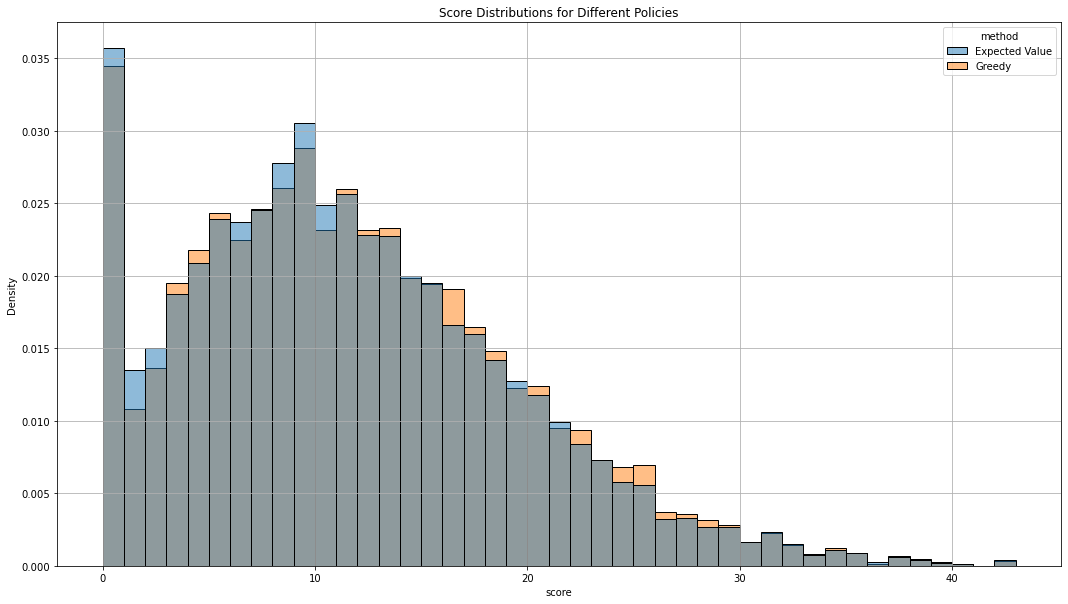

In [79]:
import seaborn as sns
plt_df = pd.DataFrame(games_played_ev)
plt_df.columns = ['score']
plt_df['method'] = "Expected Value"

tmp_df = pd.DataFrame(games_played_greedy)
tmp_df.columns = ['score']
tmp_df['method'] = "Greedy"
plt_df = pd.concat([plt_df, tmp_df])
plt.figure(figsize=(18,10))
plt.grid()
plt.title("Score Distributions for Different Policies")
sns.histplot(data=plt_df, x='score', hue='method', binwidth=1, stat='density')

In [83]:
from scipy.stats import kstest
kstest(games_played_ev, games_played_greedy, alternative='greater')

KstestResult(statistic=0.018660000000000065, pvalue=7.412305228600443e-16)

In [118]:
import numpy as np
num_wins = []
num_losses = []
day_results = []
for i in range(1_000):
    ev_scores = np.random.choice(games_played_ev, size=20)
    greedy_scores = np.random.choice(games_played_greedy, size=20)
    wins = np.sum(ev_scores < greedy_scores)
    losses = np.sum(ev_scores > greedy_scores)
    num_losses.append(losses)
    num_wins.append(wins)
    if wins > losses:
        day_results.append('win')
    if losses > wins:
        day_results.append('loss')
    if losses == wins:
        day_results.append('tie')

<AxesSubplot:title={'center':'Winning The Day With Different Strategies'}, xlabel='Result', ylabel='Count'>

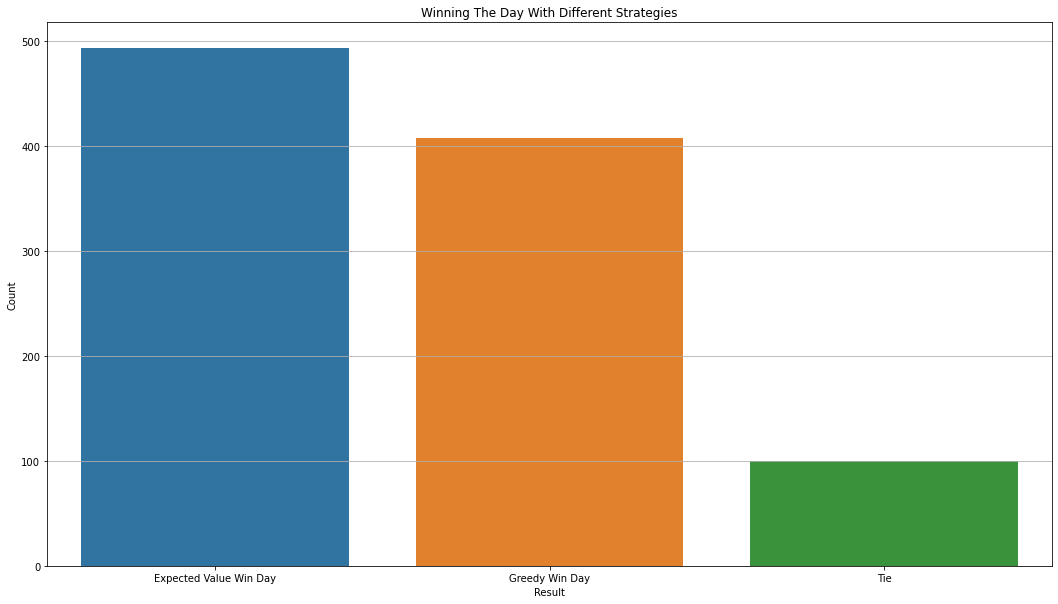

In [139]:
day_results = np.array(day_results)
table = [
    ['Expected Value Win Day', len(np.where(day_results=='win')[0])],
    ['Greedy Win Day', len(np.where(day_results=='loss')[0])],
    ['Tie', len(np.where(day_results=='tie')[0])]
]
plt_df = pd.DataFrame(table)
plt.figure(figsize=(18,10))
plt.grid()
plt.title("Winning The Day With Different Strategies")
plt_df.columns=['Result', 'Count']
sns.barplot(data=plt_df, x='Result', y='Count', ci='sd')

In [140]:
plt_df

,Result,Count
0,Expected Value Win Day,493
1,Greedy Win Day,407
2,Tie,100


<AxesSubplot:xlabel='result', ylabel='count'>

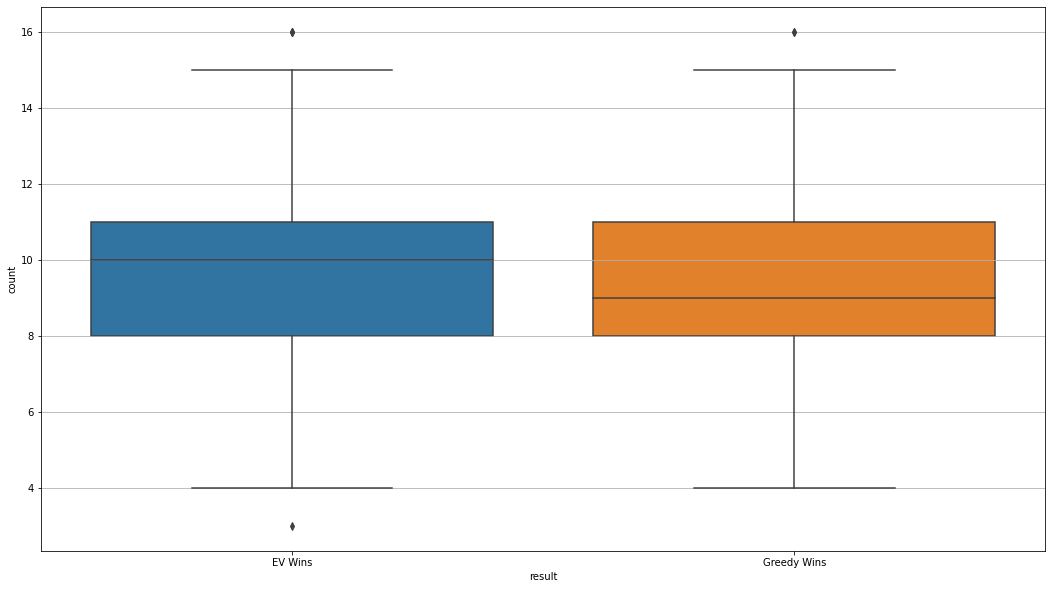

In [119]:
df1 = pd.DataFrame(num_wins)
df1.columns=['count']
df1['result'] = 'EV Wins'

df2 = pd.DataFrame(num_losses)
df2.columns=['count']
df2['result'] = 'Greedy Wins'

plt.figure(figsize=(18,10))
plt.grid()
plt_df = pd.concat([df1, df2])
sns.boxplot(data=plt_df, y='count', x='result')

In [108]:
plt_df

,count,result
0,470,EV Wins
1,486,EV Wins
2,494,EV Wins
3,498,EV Wins
4,494,EV Wins
...,...,...
995,465,Greedy Wins
996,488,Greedy Wins
997,484,Greedy Wins
998,453,Greedy Wins


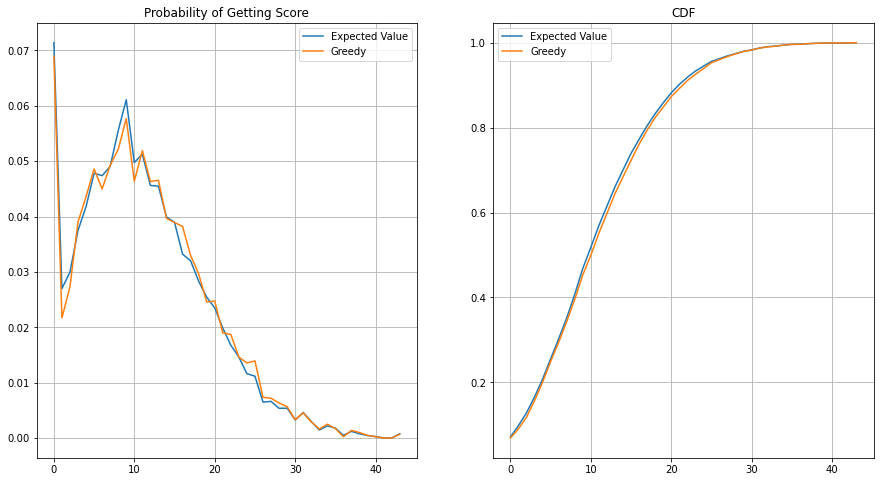

In [104]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,8))
for games_played in [games_played_ev, games_played_greedy]:
    pdf = []
    cdf = []
    for i in range(44):
        num_games = len([x for x in games_played if x == i])
        pdf.append(num_games / len(games_played))

        num_games = len([x for x in games_played if x <= i])
        cdf.append(num_games / len(games_played))
    ax1.plot(pdf)
    ax2.plot(cdf)
ax1.grid()
ax2.grid()

ax1.set_title("Probability of Getting Score")
ax2.set_title("CDF")
ax1.legend(['Expected Value', 'Greedy'])
ax2.legend(['Expected Value', 'Greedy'])



In [131]:
# Is it ever not optimal to put down the biggest tile that you can?

In [27]:
def to_bin(l):
    """
    param l: list of int, the board state
    return: int the binary representation of the board state
    """
    l = l[::-1]
    return int("".join([str(x) for x in l]), 2)

exceptions = []
for board_state in product([0,1], repeat=9):
    if sum(board_state) == 0:
        continue
    for roll in range(2, 13):
        best_score = float('inf')
        best_move = None
        for move in get_valid_moves(board_state, roll):
            new_tiles = flip_tiles(move, board_state)
            roll_score = dfs(new_tiles, 0)
            if roll_score < best_score:
                best_score = roll_score
                best_move = move
        
        if best_score == float('inf'):
            continue
        
        biggest_move = max(get_valid_moves(board_state, roll), key=to_bin)
        
        if biggest_move != best_move:
            better_option = flip_tiles(best_move, board_state)
            greedy_option = flip_tiles(biggest_move, board_state)
            exceptions.append([pretty_print_roll(board_state), roll, pretty_print_roll(best_move), dfs(better_option, 0), dfs(greedy_option, 0)])

            exceptions = sorted(exceptions, key=lambda x: x[-2] - x[1])
df = pd.DataFrame(exceptions[:5])
df.columns = ["Board", 'Roll', 'Best Move', "Expected Value", "Greedy Value"]
df

In [ ]:
# We can calculate the probability of winning a game and probability of tieing a game for every possible score
# We can do this via sampling

In [194]:
class P2Policy(object):
    def __init__(self, to_beat):
        self.to_beat = to_beat
        self.memoize_win_prob = {}
        self.wins = None
        self.losses = None
        self.ties = None
        
    def create_policy(self):
        full_board = tuple([1 for x in range(1,10)])
        return self._dfs_win_prob(full_board, 0, self.to_beat)
        
    def _dfs_win_prob(self, tiles, roll, to_beat):
        if (tiles, roll) in self.memoize_win_prob:
            return self.memoize_win_prob[(tiles, roll)]
        if roll == 0:
            total = 0
            for my_roll, prob in dice_probs.items():
                total += self._dfs_win_prob(tiles, my_roll, to_beat) * prob
            memoize[(tiles, roll)] = total
            return total
        best_score = -1
        for move in get_valid_moves(tiles, roll):
            new_tiles = flip_tiles(move, tiles)
            roll_score = self._dfs_win_prob(new_tiles, 0, to_beat)
            if roll_score > best_score:
                best_score = roll_score
        if best_score == -1:
            best_score = float(score_tiles(tiles) <= to_beat)
        self.memoize_win_prob[(tiles, roll)] = best_score
        return best_score

    def get_stats(self):
        if self.wins is not None:
            return self.wins / 10_000, self.losses / 10_000, self.ties / 10_000
        wins, losses, ties = 0, 0, 0
        for i in range(10_000):
            result = self.simulate()
            if result < self.to_beat:
                wins += 1
            if result > self.to_beat:
                losses += 1
            if result == self.to_beat:
                ties += 1
        self.wins, self.losses, self.ties = wins, losses, ties
        return wins / 10_000, losses / 10_000, ties / 10_000
    
    def get_move_best(self, board_state, possible_moves):
        best_score = -1
        best_move = None
        for move in possible_moves:
            new_tiles = flip_tiles(move, board_state)
            roll_score = self._dfs_win_prob(new_tiles, 0, self.to_beat)
            if roll_score > best_score:
                best_score = roll_score
                best_move = move
        return best_move


    def simulate(self):
        my_tiles = tuple([1 for x in range(1,10)])
        while True:
            d1, d2 = random.randint(1,6), random.randint(1,6)

            possible_moves = get_valid_moves(my_tiles, d1+d2)
            if len(possible_moves) == 0:
                return score_tiles(my_tiles)
            move = self.get_move_best(my_tiles, possible_moves)
            my_tiles = flip_tiles(move, my_tiles)

In [195]:
expected_value_score_pdf = []
for i in range(0, max(games_played_ev)+1):
    my_games = len([x for x in games_played_ev if x == i])
    expected_value_score_pdf.append(my_games/len(games_played_ev))

In [206]:
total_win, total_loss, total_tie = 0, 0, 0
policies = []
for i in range(0, max(games_played_ev)+1):
    if i % 5 == 0:
        print(f"Calculating Policy for {i}")
    policy = P2Policy(i)
    policies.append(policy)
    
    w, l, t = policy.get_stats()
    prob_of_case = expected_value_score_pdf[i]
    total_win += w * prob_of_case
    total_loss += l * prob_of_case
    total_tie += t * prob_of_case
total_win, total_loss, total_tie

Calculating Policy for 0
Calculating Policy for 5
Calculating Policy for 10
Calculating Policy for 15
Calculating Policy for 20
Calculating Policy for 25
Calculating Policy for 30
Calculating Policy for 35
Calculating Policy for 40


(0.47731662299999983, 0.47755383199999984, 0.045129544999999986)

In [209]:
size=1_000_000
g1 = np.random.choice(games_played_ev, size=size)
g2 = np.random.choice(games_played_ev, size=size)
self_wins = len(np.where(g1 > g2)[0])
self_loss = len(np.where(g1 < g2)[0])
self_tie = len(np.where(g1 == g2)[0])
print(self_wins / size, self_loss / size, self_tie / size)

0.479137 0.479201 0.041662
